# 06: Some More Modeling

### Imported Libraries

In [1]:
import sys
print('Python version: %s' % (sys.version))
from collections import Counter
print('\tCounter imported.')

# data management
print('\nData Management Libraries')
import pandas as pd
print('\tpandas version: %s' % (pd.__version__))
import numpy as np
print('\tnumpy version: %s' % (np.__version__))
import regex as re
print('\tregex version: %s' % (re.__version__))

# visualizing
print('\nVisualization Libraries')
from matplotlib import pyplot as plt
import matplotlib
print('\tmatplotlib version: %s' % (matplotlib.__version__))
import seaborn as sns
print('\tseaborn version: %s' % (sns.__version__))

# modeling
print('\nModeling Libraries')
import imblearn
print('\timblearn version: %s' % imblearn.__version__)
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
import sklearn
print('\tsklearn version: %s' % sklearn.__version__)
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score
from sklearn.metrics import plot_precision_recall_curve, precision_recall_curve

Python version: 3.8.8 (default, Feb 24 2021, 15:54:32) [MSC v.1928 64 bit (AMD64)]
	Counter imported.

Data Management Libraries
	pandas version: 1.2.3
	numpy version: 1.19.2
	regex version: 2.5.91

Visualization Libraries
	matplotlib version: 3.3.4
	seaborn version: 0.11.1

Modeling Libraries
	imblearn version: 0.8.0
	sklearn version: 0.24.1


### Update Library Settings

In [2]:
# set random state for reproducibility
random_state = 42

# default numpy settings
np.set_printoptions(edgeitems=3)
np.core.arrayprint._line_width = 80

# update settings
np.set_printoptions(edgeitems=15, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))

# update pandas settings
pd.options.display.max_columns = 12
pd.set_option('max_colwidth', 100) # sets the max number of columns before truncating with an ellipse
pd.options.display.max_rows = 500
pd.set_option('precision',6)

### Helper Functions

In [17]:
def generate_model_report(y_actual, y_predicted):
    print("Accuracy\t= %.2f" % (accuracy_score(y_actual, y_predicted)))
    print("Precision\t= %.2f" % (precision_score(y_actual, y_predicted)))
    print("Recall\t\t= %.2f" % (recall_score(y_actual, y_predicted)))
    print("F1 Score\t= %.2f" % (f1_score(y_actual, y_predicted)))
    pass

def generate_auc_roc_curve(clf, X_test, y_test):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="AUC ="+str('%.2f' % (auc)))
    plt.legend(loc=4)
    plt.show()
    pass

def generate_roc_curve(clf, X_test, y_test):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    plt.title('ROC Curve')
    plot_roc_curve(clf, X_test, y_test, ax=ax)
    plt.show()
    
def plot_prc_roc(clf,X_test,y_test):
    fig, ax = plt.subplots(1,2,figsize=(12,4))
    plot_roc_curve(clf,X_test,y_test,ax=ax[0])
    ax[0].set_title('ROC Curve')
    plot_precision_recall_curve(clf,X_test,y_test,ax=ax[1])
    ax[1].set_title('Precision-Recall Curve')
    plt.show()
    
def plot_feature_correlation_heatmap(df,title,xsize,ysize):
    fig, ax = plt.subplots(1,1,figsize=(xsize,ysize))
    corr=df.corr()
    sns.heatmap(corr,cmap='coolwarm_r',annot_kws={'size':20},ax=ax)
    ax.set_title(title,fontsize=14)
    plt.show()

### Import Dataframe

In [4]:
df = pd.read_csv('../data/creditcard_03_notScaled.csv')

In [5]:
df.shape

(284807, 31)

In [6]:
df.head()

,Time_DayAware,Amount,V1,V2,V3,V4,...,V24,V25,V26,V27,V28,Class
0,0.0,149.62,-1.359807,-0.072781,2.536347,1.378155,...,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,0.0,2.69,1.191857,0.266151,0.166480,0.448154,...,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,1.0,378.66,-1.358354,-1.340163,1.773209,0.379780,...,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.0,123.50,-0.966272,-0.185226,1.792993,-0.863291,...,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,2.0,69.99,-1.158233,0.877737,1.548718,0.403034,...,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [7]:
df.describe()

,Time_DayAware,Amount,V1,V2,V3,V4,...,V24,V25,V26,V27,V28,Class
count,284807.000000,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,52336.622709,88.349619,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,...,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,0.001727
std,21049.420490,250.120109,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,...,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,0.041527
min,0.000000,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,...,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,38153.500000,5.600000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,...,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,0.000000
50%,54039.000000,22.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,...,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,0.000000
75%,69587.000000,77.165000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,...,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,0.000000
max,86398.000000,25691.160000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,...,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,1.000000


### Train, Test

In [8]:
X = df.drop('Class', axis=1)     # drop the output series from the dataset to isolate inputs (independent features)
y = df['Class']     # set y to the output series (dependent feature)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7)     # setting training size of dataset to 70%

### Random Forest Classifier


[[85302     3]
 [   31   107]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85305
           1       0.97      0.78      0.86       138

    accuracy                           1.00     85443
   macro avg       0.99      0.89      0.93     85443
weighted avg       1.00      1.00      1.00     85443




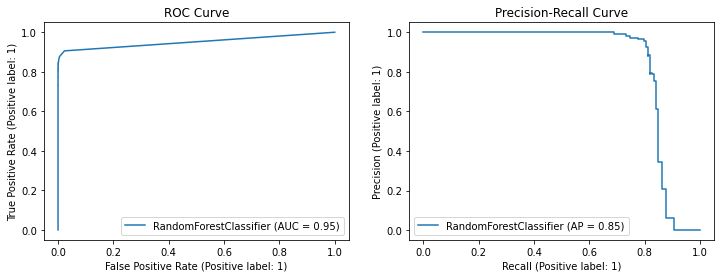

Accuracy	= 1.00
Precision	= 0.97
Recall		= 0.78
F1 Score	= 0.86


In [9]:
clf = RandomForestClassifier(random_state=random_state)     # instantiate random forest classifier class object
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test) # predict

print()
print(confusion_matrix(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))
print()
plot_prc_roc(clf,X_test,y_test)
generate_model_report(y_test,y_pred)

### Random Forest Classifier, equal weight

In [10]:
not_fraud_count = len(df.Class[df.Class == 0])
fraud_count = len(df.Class[df.Class == 1])

class_weight = dict({
    0 : 1,
    1 : (not_fraud_count/fraud_count)
})
class_weight

{0: 1, 1: 577.8760162601626}


[[85302     3]
 [   30   108]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85305
           1       0.97      0.78      0.87       138

    accuracy                           1.00     85443
   macro avg       0.99      0.89      0.93     85443
weighted avg       1.00      1.00      1.00     85443




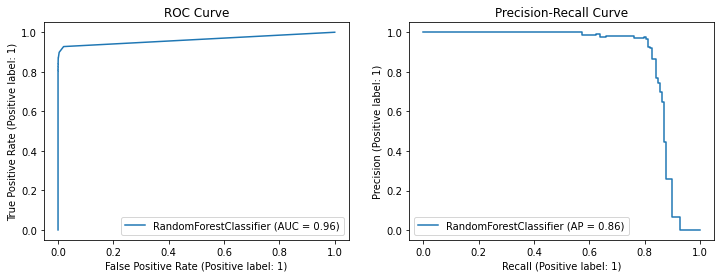

Accuracy	= 1.00
Precision	= 0.97
Recall		= 0.78
F1 Score	= 0.87


In [11]:
clf = RandomForestClassifier(random_state=random_state, class_weight=class_weight)     # instantiate random forest classifier class object
clf.fit(X_train, y_train)          # fit dataset
y_pred = clf.predict(X_test) # predict

print()
print(confusion_matrix(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))
print()
plot_prc_roc(clf,X_test,y_test)
generate_model_report(y_test,y_pred)

### Oversampling with Smote, Random Forest Classifier

In [14]:
sm = SMOTE(random_state=random_state)
smX_train,smy_train = sm.fit_resample(X_train,y_train)
print('Before fit: %s' % Counter(y_train))
print('After fit: %s' % Counter(smy_train))

Before fit: Counter({0: 199010, 1: 354})
After fit: Counter({0: 199010, 1: 199010})


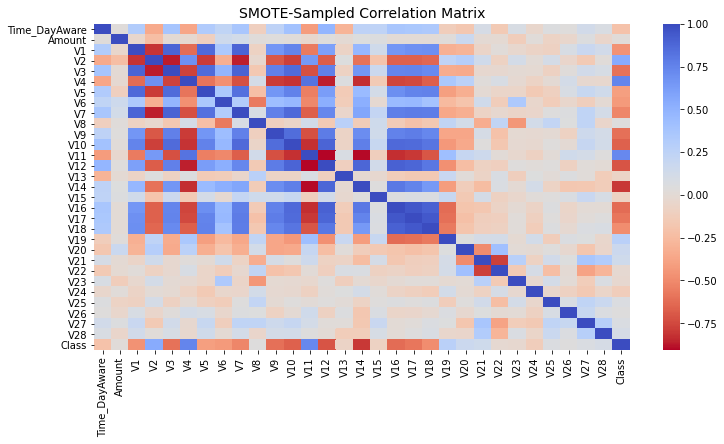

In [18]:
smote_df = smX_train.copy()
smote_df['Class'] = smy_train.copy()
plot_feature_correlation_heatmap(smote_df,'SMOTE-Sampled Correlation Matrix',12,6)


[[85292    13]
 [   22   116]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85305
           1       0.90      0.84      0.87       138

    accuracy                           1.00     85443
   macro avg       0.95      0.92      0.93     85443
weighted avg       1.00      1.00      1.00     85443




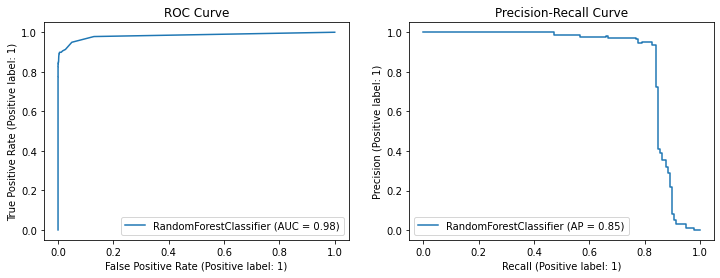

Accuracy	= 1.00
Precision	= 0.90
Recall		= 0.84
F1 Score	= 0.87


In [19]:
clf = RandomForestClassifier(random_state=random_state)     # instantiate random forest classifier class object
clf.fit(smX_train,smy_train)
y_pred = clf.predict(X_test) # predict


print()
print(confusion_matrix(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))
print()
plot_prc_roc(clf,X_test,y_test)
generate_model_report(y_test,y_pred)

## Ensemble Techniques


[[82440  2865]
 [   10   128]]

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     85305
           1       0.04      0.93      0.08       138

    accuracy                           0.97     85443
   macro avg       0.52      0.95      0.53     85443
weighted avg       1.00      0.97      0.98     85443




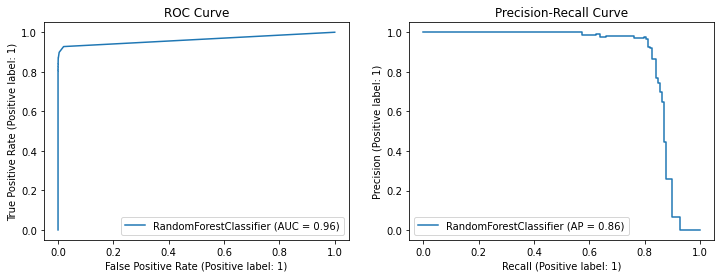

Accuracy	= 0.97
Precision	= 0.04
Recall		= 0.93
F1 Score	= 0.08


In [12]:
easy = EasyEnsembleClassifier()
easy.fit(X_train,y_train)
y_pred = easy.predict(X_test)       # predict

print()
print(confusion_matrix(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))
print()
plot_prc_roc(clf,X_test,y_test)
generate_model_report(y_test,y_pred)

## XgBoost


[[85277    28]
 [   36   102]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85305
           1       0.78      0.74      0.76       138

    accuracy                           1.00     85443
   macro avg       0.89      0.87      0.88     85443
weighted avg       1.00      1.00      1.00     85443




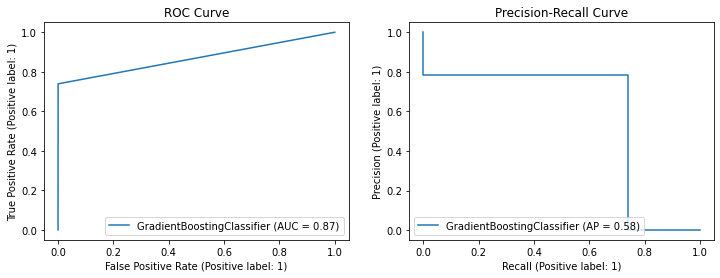

Accuracy	= 1.00
Precision	= 0.78
Recall		= 0.74
F1 Score	= 0.76


In [13]:
%%time
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1,random_state=42)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)       # predict

print()
print(confusion_matrix(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))
print()
plot_prc_roc(clf,X_test,y_test)
generate_model_report(y_test,y_pred)